In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка данных

С помощью данного датасета будем решать задачу бинарной классификации. Определять является гриб ядовитым (к ним же отнесены и несъедобные/нежелательные для употребления в пищу грибы) или съедобным

**Целевая перменная** - класс гриба (e - съедобный, p - ядовитый)

Главная задача определить, что гриб несъедобный, чтобы человек его не съел и не отравился

Несъедобный гриб - positive
Съедобный гриб - negative

Здача максимизировать recall, чтобы модель, как можно реже называла несъедобный гриб съедобным.

In [2]:
df = pd.read_csv('/kaggle/input/mushroom-classification/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
df.shape

(8124, 23)

In [4]:
print('Все колонки: ', df.columns.tolist())
df.info()

Все колонки:  ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing      

Всего 22 признака, каждый из которых является категориальным

### Гипотеза 1

Дерево решений покажет более высокий recall в определении ядовитого гриба по сравнению с логистической регрессией с one-hot кодированием, потому что все признаки категориальные

## 2. EDA

In [5]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

### Распределение классов

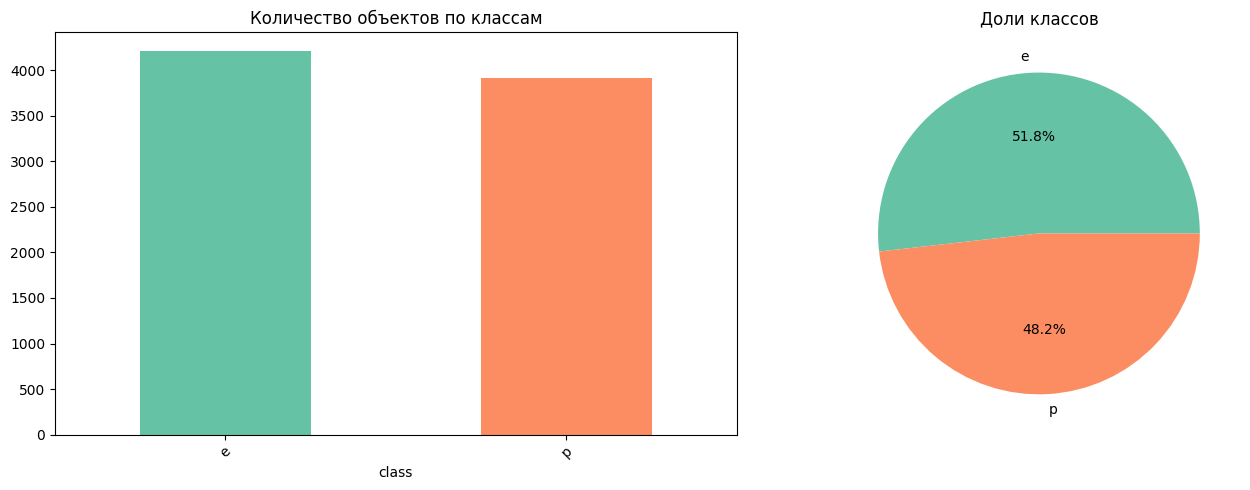

In [6]:
target_col = 'class'
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[target_col].value_counts().plot.bar(ax=axes[0], color=sns.color_palette('Set2'))
axes[0].set_title('Количество объектов по классам')
axes[0].tick_params(axis='x', rotation=45)

df[target_col].value_counts(normalize=True).plot.pie(ax=axes[1], autopct='%1.1f%%', colors=sns.color_palette('Set2'))
axes[1].set_ylabel('')
axes[1].set_title('Доли классов')
plt.tight_layout()
plt.show()

Классы сбалансированы

In [7]:
for col in df.columns:
    print(col, df[col].nunique(), df[col].unique())

class 2 ['p' 'e']
cap-shape 6 ['x' 'b' 's' 'f' 'k' 'c']
cap-surface 4 ['s' 'y' 'f' 'g']
cap-color 10 ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises 2 ['t' 'f']
odor 9 ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment 2 ['f' 'a']
gill-spacing 2 ['c' 'w']
gill-size 2 ['n' 'b']
gill-color 12 ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape 2 ['e' 't']
stalk-root 5 ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring 4 ['s' 'f' 'k' 'y']
stalk-surface-below-ring 4 ['s' 'f' 'y' 'k']
stalk-color-above-ring 9 ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring 9 ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type 1 ['p']
veil-color 4 ['w' 'n' 'o' 'y']
ring-number 3 ['o' 't' 'n']
ring-type 5 ['p' 'e' 'l' 'f' 'n']
spore-print-color 9 ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population 6 ['s' 'n' 'a' 'v' 'y' 'c']
habitat 7 ['u' 'g' 'm' 'd' 'p' 'w' 'l']


veil-type (тип вуали) в датасете всегда 'p', хотя в описании заявлено, что он может быть и 'u'. Но этот тип не представден. Его можно удалить, так как константный признак пользы при обучении модели не несет

в stalk-root есть тип '?'. Это не пропуск значения, согласно описанию датасета.

In [8]:
df = df.drop('veil-type', axis = 1)

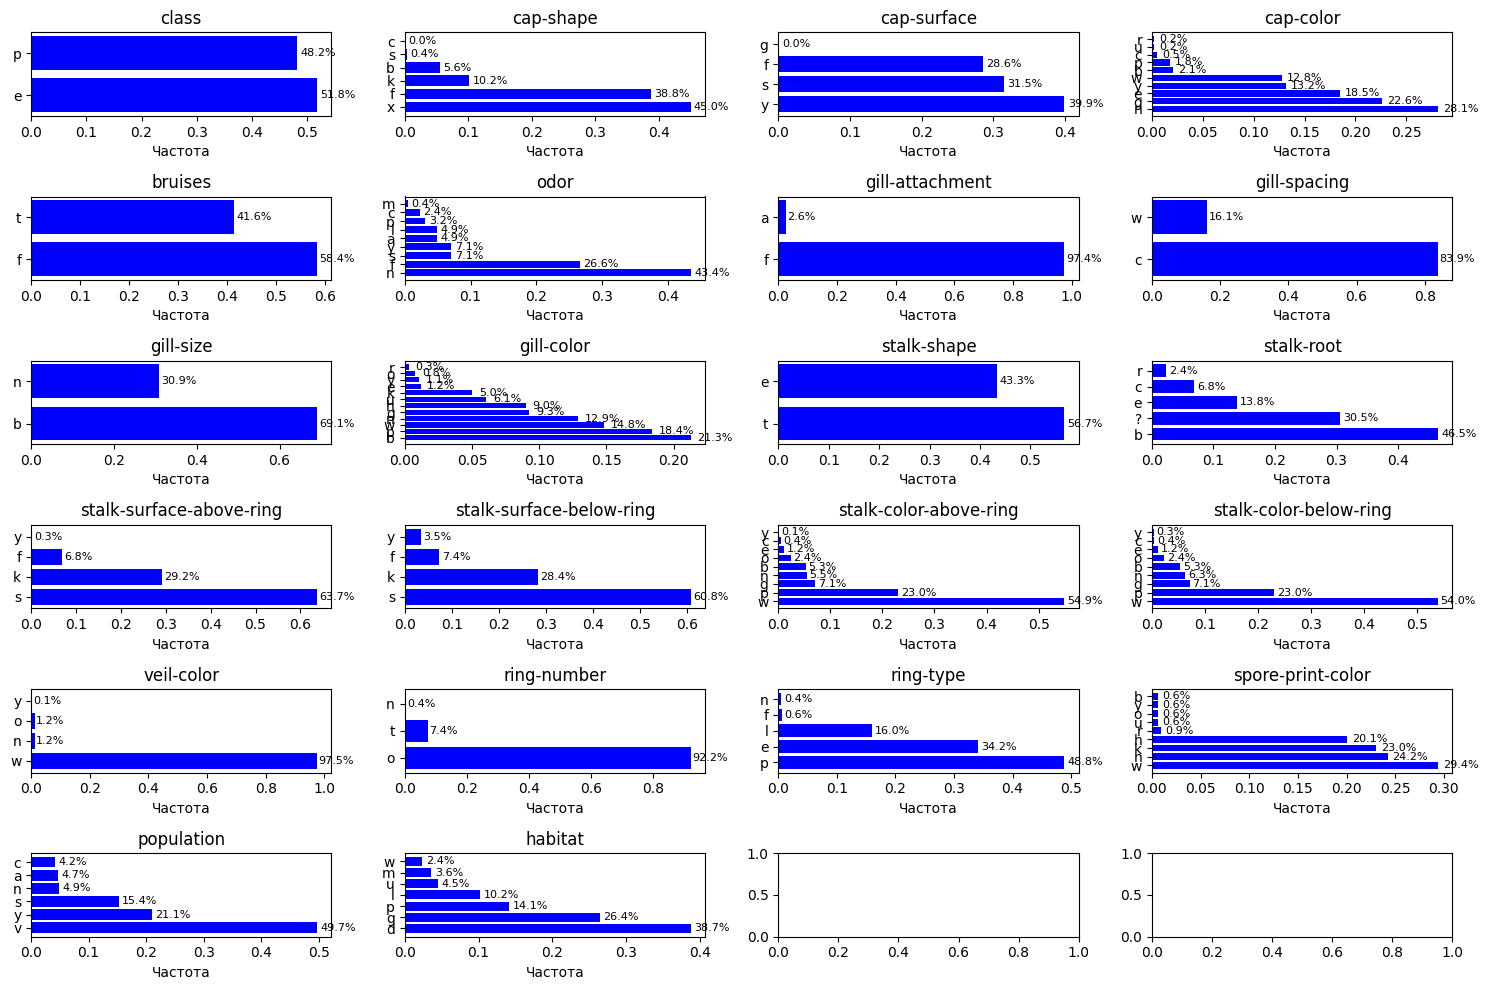

In [9]:
problematic_cols = ['gill-color', 'cap-color', 'odor', 'spore-print-color', 'stalk-color-above-ring', 'stalk-color-below-ring']

fig, axes = plt.subplots(6, 4, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    freqs = df[col].value_counts(normalize=True).sort_values(ascending=False)
    
    axes[idx].barh(range(len(freqs)), freqs.values, color='blue')
    axes[idx].set_yticks(range(len(freqs)))
    axes[idx].set_yticklabels(freqs.index)
    axes[idx].set_xlabel('Частота')
    axes[idx].set_title(col)
    for i, (val, freq) in enumerate(freqs.items()):
        axes[idx].text(freq + 0.005, i, f'{freq:.1%}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
pd.crosstab(df['gill-attachment'], df['class'], normalize='index') * 100

class,e,p
gill-attachment,,
a,91.428571,8.571429
f,50.745514,49.254486


In [11]:
pd.crosstab(df['veil-color'], df['class'], normalize='index') * 100

class,e,p
veil-color,,
n,100.000000,0.000000
o,100.000000,0.000000
w,50.681474,49.318526
y,0.000000,100.000000


In [12]:
pd.crosstab(df['ring-number'], df['class'], normalize='index') * 100

class,e,p
ring-number,,
n,0.000000,100.000000
o,49.145299,50.854701
t,88.000000,12.000000


In [13]:
pd.crosstab(df['ring-type'], df['class'], normalize='index') * 100

class,e,p
ring-type,,
e,36.311239,63.688761
f,100.000000,0.000000
l,0.000000,100.000000
n,0.000000,100.000000
p,79.435484,20.564516


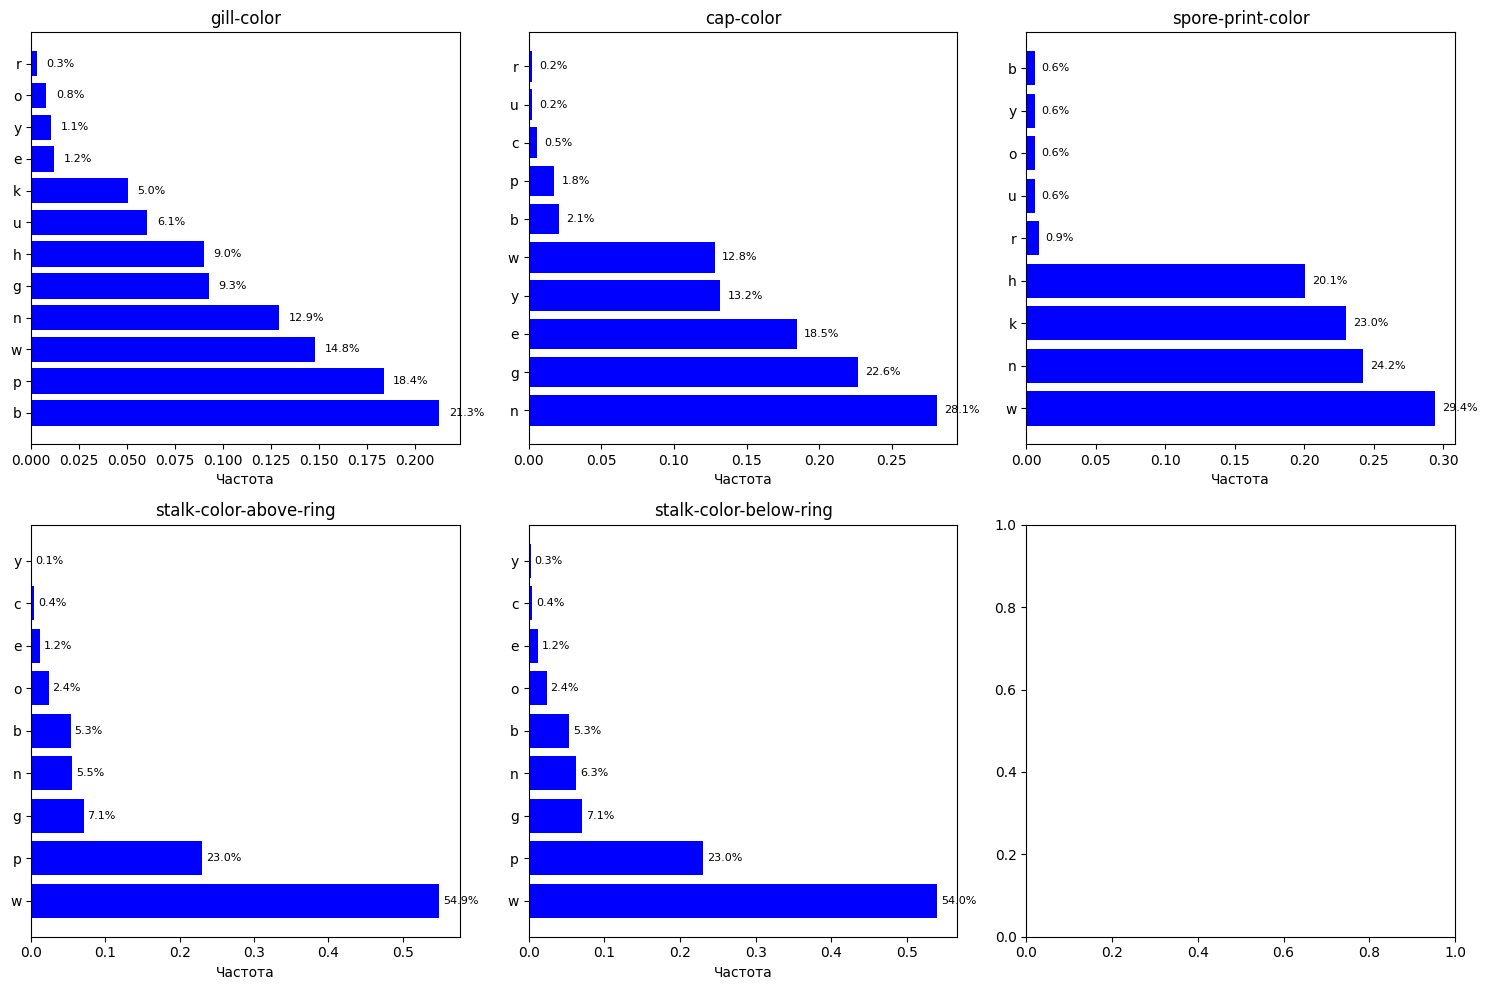

In [14]:
problematic_cols = ['gill-color', 'cap-color', 'spore-print-color', 'stalk-color-above-ring', 'stalk-color-below-ring']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(problematic_cols):
    freqs = df[col].value_counts(normalize=True).sort_values(ascending=False)
    
    axes[idx].barh(range(len(freqs)), freqs.values, color='blue')
    axes[idx].set_yticks(range(len(freqs)))
    axes[idx].set_yticklabels(freqs.index)
    axes[idx].set_xlabel('Частота')
    axes[idx].set_title(col)
    for i, (val, freq) in enumerate(freqs.items()):
        axes[idx].text(freq + 0.005, i, f'{freq:.1%}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

 ### Гипотеза 2
 Из-за большого числа редких категорий логистическая регрессия будет склонна к переобучению. Объеденение редких категорий с частотой меньше некоторого значений в 'other' снизит дисперсию и повысит recall на тестовой выборке

In [15]:
threshold = 0.02

for col in problematic_cols:
    freq = df[col].value_counts(normalize=True)
    ct = pd.crosstab(df[col], df['class'], normalize='index')
    ct['freq'] = ct.index.map(freq)
    ct = ct.sort_values('freq', ascending=False)
    ct['rare'] = ct['freq'] < threshold
    
    print(f"\n=== {col} ===")
    print(ct.round(3))


=== gill-color ===
class           e      p   freq   rare
gill-color                            
b           0.000  1.000  0.213  False
p           0.571  0.429  0.184  False
w           0.795  0.205  0.148  False
n           0.893  0.107  0.129  False
g           0.330  0.670  0.093  False
h           0.279  0.721  0.090  False
u           0.902  0.098  0.061  False
k           0.843  0.157  0.050  False
e           1.000  0.000  0.012   True
y           0.744  0.256  0.011   True
o           1.000  0.000  0.008   True
r           0.000  1.000  0.003   True

=== cap-color ===
class          e      p   freq   rare
cap-color                            
n          0.553  0.447  0.281  False
g          0.561  0.439  0.226  False
e          0.416  0.584  0.185  False
y          0.373  0.627  0.132  False
w          0.692  0.308  0.128  False
b          0.286  0.714  0.021  False
p          0.389  0.611  0.018   True
c          0.727  0.273  0.005   True
u          1.000  0.000  0.002   Tr

Однако тут же видим, что многие редкие категории являются чистыми предикторами. Они могут сильно повлиять на результат и с высокой точностью определить съедобность гриба. Однако многих таких признаков мало экземпляров. Стоит это учитывать для гипотезы 2

In [16]:
# создадим два датасета с объедененными редкими признаками
# выберем порог в 2% и 6%

def combine_rare(df, col, threshold):
    freqs = df[col].value_counts(normalize = True)
    rare = freqs[freqs < threshold].index
    new_values = ['other' if x in rare else x for x in df[col]]
    df[col] = new_values
    return df

df_logreg_other_2 = df.copy()
df_logreg_other_6 = df.copy()

for column in problematic_cols:
    df_logreg_other_2 = combine_rare(df_logreg_other_2, column, 0.02)
    df_logreg_other_6 = combine_rare(df_logreg_other_6, column, 0.06)



### 3. Подготовка данных

In [17]:
y = [0 if x == 'e' else 1 for x in df['class']]
df['class'] = y
df_logreg_other_2['class'] = y
df_logreg_other_6['class'] = y
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,0,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,0,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,1,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,0,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


OneHotEncoder - для логистической регрессии. Для дерева оставляем категориальные признаки

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
                             ConfusionMatrixDisplay)

X_logreg = df.drop('class', axis=1)
y = df['class']

X_logreg_2 = df_logreg_other_2.drop('class', axis=1)

X_logreg_6 = df_logreg_other_6.drop('class', axis=1)

X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(
    X_logreg, y, test_size=0.3, random_state=42, stratify=y
)

X_train_logreg_2, X_test_logreg_2, y_train_logreg_2, y_test_logreg_2 = train_test_split(
    X_logreg_2, y, test_size=0.3, random_state=42, stratify=y
)

X_train_logreg_6, X_test_logreg_6, y_train_logreg_6, y_test_logreg_6 = train_test_split(
    X_logreg_6, y, test_size=0.3, random_state=42, stratify=y
)

In [19]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train_logreg)

X_train_logreg_encoded = ohe.transform(X_train_logreg)
X_test_logreg_encoded = ohe.transform(X_test_logreg)

feature_names = ohe.get_feature_names_out(X_logreg.columns)

X_train_logreg = pd.DataFrame(X_train_logreg_encoded, columns=feature_names, index=X_train_logreg.index)
X_test_logreg = pd.DataFrame(X_test_logreg_encoded, columns=feature_names, index=X_test_logreg.index)

print(f"Исходные данные: train shape {X_train_logreg.shape}, test shape {X_test_logreg.shape}")

Исходные данные: train shape (5686, 95), test shape (2438, 95)


In [20]:
ohe_2 = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ohe_2.fit(X_train_logreg_2)

X_train_logreg_2_encoded = ohe_2.transform(X_train_logreg_2)
X_test_logreg_2_encoded = ohe_2.transform(X_test_logreg_2)

feature_names_2 = ohe_2.get_feature_names_out(X_logreg_2.columns)

X_train_logreg_2 = pd.DataFrame(X_train_logreg_2_encoded, columns=feature_names_2, index=X_train_logreg_2.index)
X_test_logreg_2 = pd.DataFrame(X_test_logreg_2_encoded, columns=feature_names_2, index=X_test_logreg_2.index)

print(f"Порог 2%: train shape {X_train_logreg_2.shape}, test shape {X_test_logreg_2.shape}")

Порог 2%: train shape (5686, 81), test shape (2438, 81)


In [21]:
ohe_6 = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ohe_6.fit(X_train_logreg_6)

X_train_logreg_6_encoded = ohe_6.transform(X_train_logreg_6)
X_test_logreg_6_encoded = ohe_6.transform(X_test_logreg_6)

feature_names_6 = ohe_6.get_feature_names_out(X_logreg_6.columns)

X_train_logreg_6 = pd.DataFrame(X_train_logreg_6_encoded, columns=feature_names_6, index=X_train_logreg_6.index)
X_test_logreg_6 = pd.DataFrame(X_test_logreg_6_encoded, columns=feature_names_6, index=X_test_logreg_6.index)

print(f"Порог 6%: train shape {X_train_logreg_6.shape}, test shape {X_test_logreg_6.shape}")

Порог 6%: train shape (5686, 74), test shape (2438, 74)


In [22]:
log_reg_bin = LogisticRegression(max_iter=1000, random_state=42)
log_reg_bin.fit(X_train_logreg, y_train_logreg)

y_pred_bin = log_reg_bin.predict(X_test_logreg)
y_proba_bin = log_reg_bin.predict_proba(X_test_logreg)[:, 1]

print("Исходные данные:")
print(f"Accuracy: {accuracy_score(y_test_logreg, y_pred_bin):.4f}")
print(f"F1: {f1_score(y_test_logreg, y_pred_bin):.4f}")
print(f"Recall: {recall_score(y_test_logreg, y_pred_bin):.4f}")

Исходные данные:
Accuracy: 0.9984
F1: 0.9983
Recall: 0.9966


In [23]:
log_reg_bin_2 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_bin_2.fit(X_train_logreg_2, y_train_logreg_2)

y_pred_bin_2 = log_reg_bin_2.predict(X_test_logreg_2)
y_proba_bin_2 = log_reg_bin_2.predict_proba(X_test_logreg_2)[:, 1]

print("\nПорог 2%:")
print(f"Accuracy: {accuracy_score(y_test_logreg_2, y_pred_bin_2):.4f}")
print(f"F1: {f1_score(y_test_logreg_2, y_pred_bin_2):.4f}")
print(f"Recall: {recall_score(y_test_logreg_2, y_pred_bin_2):.4f}")


Порог 2%:
Accuracy: 0.9967
F1: 0.9966
Recall: 0.9966


In [24]:
log_reg_bin_6 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_bin_6.fit(X_train_logreg_6, y_train_logreg_6)

y_pred_bin_6 = log_reg_bin_6.predict(X_test_logreg_6)
y_proba_bin_6 = log_reg_bin_6.predict_proba(X_test_logreg_6)[:, 1]

print("\nПорог 6%:")
print(f"Accuracy: {accuracy_score(y_test_logreg_6, y_pred_bin_6):.4f}")
print(f"F1: {f1_score(y_test_logreg_6, y_pred_bin_6):.4f}")
print(f"Recall: {recall_score(y_test_logreg_6, y_pred_bin_6):.4f}")


Порог 6%:
Accuracy: 0.9967
F1: 0.9966
Recall: 0.9966


In [47]:
pd.DataFrame({
    'Модель': ['Исходные', 'Порог 2%', 'Порог 6%'],
    'Accuracy': [accuracy_score(y_test_logreg, y_pred_bin),
                 accuracy_score(y_test_logreg_2, y_pred_bin_2),
                 accuracy_score(y_test_logreg_6, y_pred_bin_6)],
    'F1': [f1_score(y_test_logreg, y_pred_bin),
           f1_score(y_test_logreg_2, y_pred_bin_2),
           f1_score(y_test_logreg_6, y_pred_bin_6)],
    'Recall': [recall_score(y_test_logreg, y_pred_bin),
               recall_score(y_test_logreg_2, y_pred_bin_2),
               recall_score(y_test_logreg_6, y_pred_bin_6)]
}).round(4)

,Модель,Accuracy,F1,Recall
0,Исходные,0.9984,0.9983,0.9966
1,Порог 2%,0.9967,0.9966,0.9966
2,Порог 6%,0.9967,0.9966,0.9966


Подозрительно высокая точность

### Гипотеза 2 - ИТОГ

Можно считать, что гипотеза подтвердилась, потому что recall главная для нас переменная не изменяется. Значит, значение можно заменять на other

### Гипотеза 3
При EDA был упущен критерий супер предиктор, только на основании, которого можно с высокой точностью классифицировать гриб

In [26]:
for col in df.columns:
    if col != 'class':
        ct = pd.crosstab(df[col], df['class'])
        accuracy_by_feature = (ct.values.max(axis=1).sum() / len(df))
        print(f"{col}: {accuracy_by_feature:.3f}")

cap-shape: 0.564
cap-surface: 0.581
cap-color: 0.595
bruises: 0.744
odor: 0.985
gill-attachment: 0.518
gill-spacing: 0.616
gill-size: 0.756
gill-color: 0.805
stalk-shape: 0.553
stalk-root: 0.646
stalk-surface-above-ring: 0.774
stalk-surface-below-ring: 0.766
stalk-color-above-ring: 0.716
stalk-color-below-ring: 0.714
veil-color: 0.519
ring-number: 0.538
ring-type: 0.775
spore-print-color: 0.868
population: 0.722
habitat: 0.690


### Гипотеза 3 - ИТОГ
Гипотеза подтвердилась. 'odor' - запах является супер предиктором. Его точность 98.5%, что всего на 1.3% ниже, чем с моделью линейной ригрессии.

 ### Гипотеза 4
 Baseline модель по признаку 'odor' будет показывать высокие значение метрик > 95%

In [27]:
rule = df.groupby('odor')['class'].agg(lambda x: x.mode()[0])
        
predictions = df['odor'].map(rule)

acc_baseline = (predictions == df['class']).mean()

y_true = df['class']
y_pred = predictions

tp = ((y_pred == 1) & (y_true == 1)).sum()
fn = ((y_pred == 0) & (y_true == 1)).sum()

recall_baseline = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"odor: acc={acc_baseline:.3f}, recall={recall_baseline:.3f}")

odor: acc=0.985, recall=0.969


### Гипотеза 4 - ИТОГ
Гипотеза подтверидилась, поскольку признак является супер предиктором

In [28]:
X_odor = df[['odor']]
y = df['class']

X_train_odor, X_test_odor, y_train_odor, y_test_odor = train_test_split(
    X_odor, y, test_size=0.3, random_state=42, stratify=y
)

ohe_odor = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ohe_odor.fit(X_train_odor)

X_train_odor_encoded = ohe_odor.transform(X_train_odor)
X_test_odor_encoded = ohe_odor.transform(X_test_odor)

log_reg_odor = LogisticRegression(max_iter=1000, random_state=42)
log_reg_odor.fit(X_train_odor_encoded, y_train_odor)

y_pred_odor = log_reg_odor.predict(X_test_odor_encoded)

print("=== МОДЕЛЬ ТОЛЬКО НА ODOR ===")
print(f"Accuracy: {accuracy_score(y_test_odor, y_pred_odor):.4f}")
print(f"Recall: {recall_score(y_test_odor, y_pred_odor):.4f}")
print(f"F1: {f1_score(y_test_odor, y_pred_odor):.4f}")

=== МОДЕЛЬ ТОЛЬКО НА ODOR ===
Accuracy: 0.9869
Recall: 0.9728
F1: 0.9862


In [48]:
print(f"{'Метрика':<15} {'Baseline odor':<12} {'Только odor':<12} {'Полная':<12}")
print("-" * 80)

# Accuracy
print(f"{'Accuracy':<15} {acc_baseline:.4f}       {accuracy_score(y_test_odor, y_pred_odor):.4f}       {accuracy_score(y_test_logreg, y_pred_bin):.4f}       ")

# Recall
print(f"{'Recall':<15} {recall_baseline:.4f}       {recall_score(y_test_odor, y_pred_odor):.4f}       {recall_score(y_test_logreg, y_pred_bin):.4f}    ")

Метрика         Baseline odor Только odor  Полная      
--------------------------------------------------------------------------------
Accuracy        0.9852       0.9869       0.9984       
Recall          0.9694       0.9728       0.9966    


### ИТОГ по логистической регрессии

В датасете есть супер-предиктор - запах. baseline основанная на это признаке сама по себе обеспечивает recall 97.3% и accuracy 98.5%. Полная модель увеличивает метрики на 2.5% и 1.3% соответсвенно

Даже простейшее правило показывает показатели слишком незначитель отличающиеся от модели логистической регресии, поэтому ее использование в реальности может быть нецелесообразно

### 4. Дерерво решений

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

X_encoded = X.apply(LabelEncoder().fit_transform)

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

dt_cls = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_cls.fit(X_train_tree, y_train_tree)
y_pred_dt = dt_cls.predict(X_test_tree)

print(f"Accuracy: {accuracy_score(y_test_tree, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test_tree, y_pred_dt):.4f}")

Accuracy: 0.9840
Recall: 0.9940


In [41]:
pd.DataFrame({
    'Модель': [
        'Baseline (правило по odor)',
        'LogReg (полная модель)',
        'Decesion tree (depth=5)'
    ],
    'Accuracy': [
        acc_baseline,
        accuracy_score(y_test_logreg, y_pred_bin),
        accuracy_score(y_test_tree, y_pred_dt)
    ],
    'Recall': [
        recall_baseline,
        recall_score(y_test_logreg, y_pred_bin),
        recall_score(y_test_tree, y_pred_dt)
    ],
    'F1-score': [
        f1_score(df['class'], predictions),
        f1_score(y_test_logreg, y_pred_bin),
        f1_score(y_test_tree, y_pred_dt),
    ]
}).round(4)

,Модель,Accuracy,Recall,F1-score
0,Baseline (правило по odor),0.9852,0.9694,0.9844
1,LogReg (полная модель),0.9984,0.9966,0.9983
2,Decesion tree (depth=5),0.9840,0.9940,0.9836


### Гипотеза 5
В связи с тем, что при глубине в 5 дерево уже почти достигает идеальных метрик. Поэтому незначительное увеличение глубины может привести к идеальным метрикам и дальший подбор гиперпараметров будет излишним

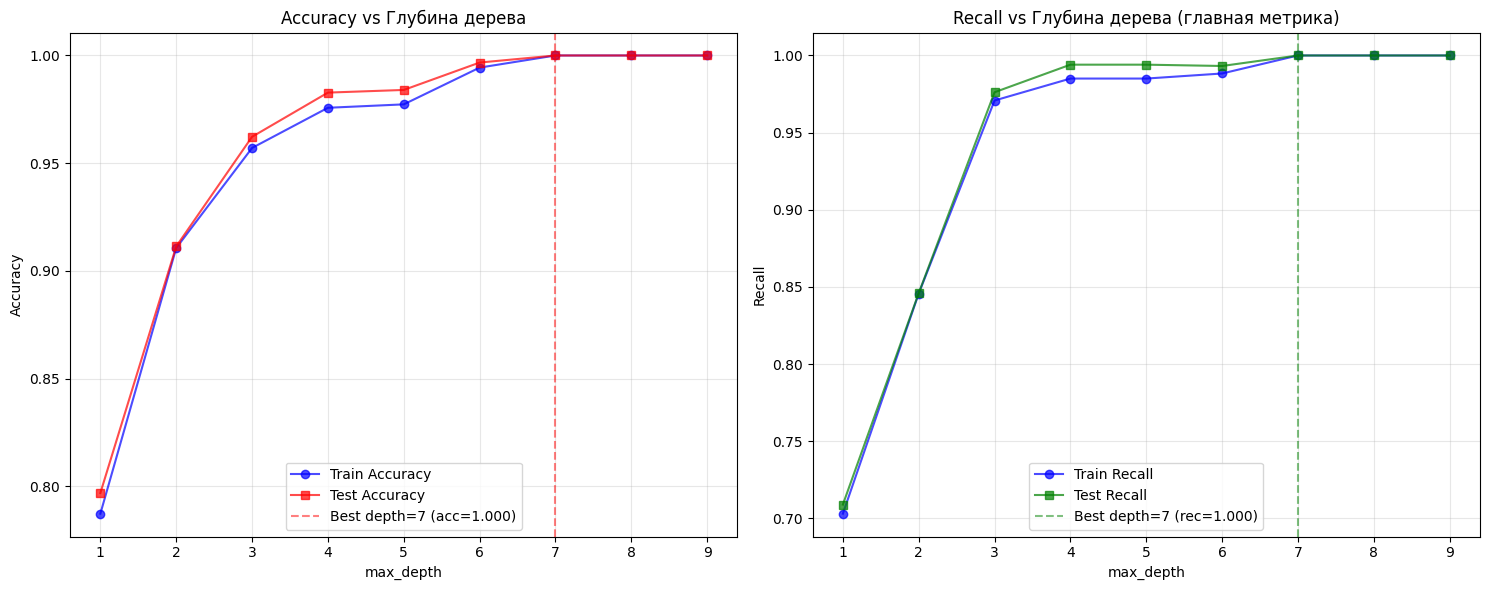

Лучшая глубина по accuracy: 7 (test_acc=1.0000)
Лучшая глубина по recall: 7 (test_rec=1.0000)


In [46]:
depths = range(5, 10)
train_acc, test_acc, train_rec, test_rec = [], [], [], []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42).fit(X_train_tree, y_train_tree)
    
    train_pred = dt.predict(X_train_tree)
    test_pred = dt.predict(X_test_tree)
    
    train_acc.append(accuracy_score(y_train_tree, train_pred))
    test_acc.append(accuracy_score(y_test_tree, test_pred))
    
    train_rec.append(recall_score(y_train_tree, train_pred))
    test_rec.append(recall_score(y_test_tree, test_pred))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = axes[0]
ax.plot(depths, train_acc, 'o-', label='Train Accuracy', color='blue', alpha=0.7)
ax.plot(depths, test_acc, 's-', label='Test Accuracy', color='red', alpha=0.7)
best_acc_depth = depths[np.argmax(test_acc)]
ax.axvline(x=best_acc_depth, color='red', linestyle='--', alpha=0.5,
           label=f'Best depth={best_acc_depth} (acc={max(test_acc):.3f})')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Глубина дерева')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(depths, train_rec, 'o-', label='Train Recall', color='blue', alpha=0.7)
ax.plot(depths, test_rec, 's-', label='Test Recall', color='green', alpha=0.7)
best_rec_depth = depths[np.argmax(test_rec)]
ax.axvline(x=best_rec_depth, color='green', linestyle='--', alpha=0.5,
           label=f'Best depth={best_rec_depth} (rec={max(test_rec):.3f})')
ax.set_xlabel('max_depth')
ax.set_ylabel('Recall')
ax.set_title('Recall vs Глубина дерева (главная метрика)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Лучшая глубина по accuracy: {best_acc_depth} (test_acc={max(test_acc):.4f})")
print(f"Лучшая глубина по recall: {best_rec_depth} (test_rec={max(test_rec):.4f})")

### Гипотеза 5 - ИТОГ

Здача классификации грибов настолько простая, что дерево решений достигло идеальных характеристик уже при глубине 7. Дальнейшее обучение нецелесообразно.

> **Замечание**
> Кросс-валидация и GridSearch нецелесообразны, потому что модель уже показывает экстримально высокое качество, которое связано со спицефичностью данных

### Гипотеза 1 - ИТОГ
Гипотеза подтвердилась и дерево решений действительно показывает более высокий recall по сравнению с логистической регресией. При глубине 7 дерево решений идельно классифицирует грибы. Это происходит в связи с тем, что все признаки категориальные. Однако расхождения в метриках менее 1%, поэтому выбор модели не принципиален

## 5. ВЫВОД
Задача классификации грибов решается практичеки иделально (recall 97%) даже без применения моделей машинного обучения на основе признака odor. Однако, если выбирать между логистической регрессией и деревом решений

- если важна простота - логистическая регрессия
- если важна идеальная точность - дерево решений